# Construction

In this section, we build LDA, QDA, and Naive Bayes classifiers. We will demo these classes on the {doc}`wine </content/appendix/data>` dataset.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

wine = datasets.load_wine()
X, y = wine.data, wine.target

## LDA

An implementation of linear discriminant analysis (LDA) is given below. The main method is `.fit()`. This method makes three important estimates. For each $k$, we estimate $\pi_k$, the class prior probability. For each class we also estimate the mean of the data in that class, $\bmu_k$. Finally, we estimate the overall covariance matrix across classes, $\bSigma$. The formulas for these estimates are detailed in the {doc}`concept section </content/c4/concept>`.

The second two methods, `.mvn_density()` and `.classify()` are for classifying new observations. `.mvn_density()` just calculates the density (up to a multiplicative constant) of a Multivariate Normal sample provided the mean vector and covariance matrix. `.classify()` actually makes the classifications for each test observation. It calculates the density for each class, $p(\bx_n|Y_n = k)$, and multiplies this by the prior class probability, $p(Y_n = k) = \pi_k$, to get a posterior class probability, $p(Y_n = k|\bx_n)$. It then predicts the class with the highest posterior probability. 

In [3]:
class LDA:
    
    ## Fitting the model 
    def fit(self, X, y):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        ## Get mu for each class and overall Sigma
        self.mu_ks = []
        self.Sigma = np.zeros((self.D, self.D))        
        for i, k in enumerate(self.unique_y):
            
            X_k = self.X[self.y == k]
            mu_k = X_k.mean(0).reshape(self.D, 1)
            self.mu_ks.append(mu_k)

            for x_n in X_k:
                x_n = x_n.reshape(-1,1)
                x_n_minus_mu_k = (x_n - mu_k)
                self.Sigma += np.dot(x_n_minus_mu_k, x_n_minus_mu_k.T)
            
        self.Sigma /= self.N
        
        
    ## Making classifications

    def _mvn_density(self, x_n, mu_k, Sigma):
        x_n_minus_mu_k = (x_n - mu_k)
        density = np.exp(-(1/2)*x_n_minus_mu_k.T @ np.linalg.inv(Sigma) @ x_n_minus_mu_k)
        return density
            
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test):
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y):
                p_x_given_y = self._mvn_density(x_n, self.mu_ks[j], self.Sigma)
                p_y_given_x = self.pi_ks[j]*p_x_given_y
                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n
            

We fit the LDA model below and classify the training observations. As the output shows, we have 100% training accuracy.

In [4]:
lda = LDA()
lda.fit(X, y)
yhat = lda.classify(X)
np.mean(yhat == y)

1.0

The function below visualizes class predictions based on the input values for a model with $\bx_n \in \mathbb{R}^2$. To apply this function, we build a model with only two columns from the `wine` dataset. We see that the decision boundaries are linear, as we expect from LDA.

In [5]:
def graph_boundaries(X, model, model_title, n0 = 100, n1 = 100, figsize = (7, 5), label_every = 4):
        
        # Generate X for plotting 
        d0_range = np.linspace(X[:,0].min(), X[:,0].max(), n0)
        d1_range = np.linspace(X[:,1].min(), X[:,1].max(), n1)
        X_plot = np.array(np.meshgrid(d0_range, d1_range)).T.reshape(-1, 2)
        
        # Get class predictions
        y_plot = model.classify(X_plot).astype(int)
        
        # Plot 
        fig, ax = plt.subplots(figsize = figsize)
        sns.heatmap(y_plot.reshape(n0, n1).T,
                   cmap = sns.color_palette('Pastel1', 3),
                   cbar_kws = {'ticks':sorted(np.unique(y_plot))})
        xticks, yticks = ax.get_xticks(), ax.get_yticks()
        ax.set(xticks = xticks[::label_every], xticklabels = d0_range.round(2)[::label_every],
               yticks = yticks[::label_every], yticklabels = d1_range.round(2)[::label_every])
        ax.set(xlabel = 'X1', ylabel = 'X2', title = model_title + ' Predictions by X1 and X2')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

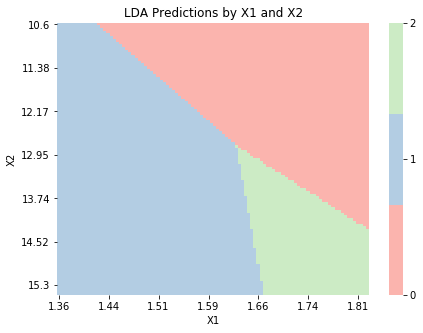

In [6]:
X_2d = X.copy()[:,2:4]
lda_2d = LDA()
lda_2d.fit(X_2d, y)
graph_boundaries(X_2d, lda_2d, 'LDA')

## QDA

The QDA model is implemented below. It is nearly identical to LDA except the covariance matrices $\bSigma_k$ are estimated separately. Again see the {doc}`concept section </content/c4/concept>` for details. 

In [10]:
class QDA:
    
    ## Fitting the model
    
    def fit(self, X, y):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        
        ## Get mu and Sigma for each class
        self.mu_ks = []
        self.Sigma_ks = []
        for i, k in enumerate(self.unique_y):
            
            X_k = self.X[self.y == k]
            mu_k = X_k.mean(0).reshape(self.D, 1)
            self.mu_ks.append(mu_k)
            
            Sigma_k = np.zeros((self.D, self.D))
            for x_n in X_k:
                x_n = x_n.reshape(-1,1)
                x_n_minus_mu_k = (x_n - mu_k)
                Sigma_k += np.dot(x_n_minus_mu_k, x_n_minus_mu_k.T)
            self.Sigma_ks.append(Sigma_k/len(X_k))
     
    ## Making classifications 
    
    def _mvn_density(self, x_n, mu_k, Sigma_k):
        x_n_minus_mu_k = (x_n - mu_k)
        density = np.linalg.det(Sigma_k)**(-1/2) * np.exp(-(1/2)*x_n_minus_mu_k.T @ np.linalg.inv(Sigma_k) @ x_n_minus_mu_k)
        return density
    
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test):
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y):

                p_x_given_y = self._mvn_density(x_n, self.mu_ks[j], self.Sigma_ks[j])
                p_y_given_x = self.pi_ks[j]*p_x_given_y
                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n
            

In [11]:
qda = QDA()
qda.fit(X, y)
yhat = qda.classify(X)
np.mean(yhat == y)

0.9943820224719101

The below plot shows predictions based on the input variables for the QDA model. As expected, the decision boundaries are quadratic, rather than linear. We also see that the area corresponding to class 2 is much smaller than the other areas. This suggests that either there were fewer observations in class 2 or the estimated variance of the input variables for observations in class 2 was smaller than the variance for observations in other classes .

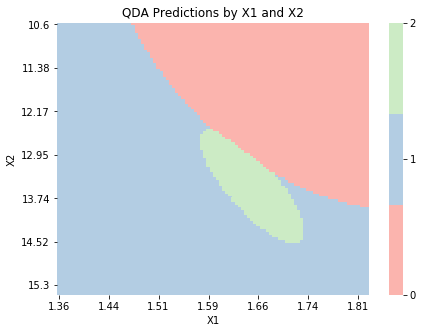

In [12]:
qda_2d = QDA()
qda_2d.fit(X_2d, y)
graph_boundaries(X_2d, qda_2d, 'QDA')

## Naive Bayes

Finally, we implement a Naive Bayes model below. This model allows us to assign each variable in our dataset a distribution, though by default they are all assumed to be Normal. Since each variable has its own distribution, estimating the model's parameters is more involved. For each variable and each class, we estimate the parameters separately through the `_estimate_class_parameters`. The structure below allows for Normal, Bernoulli, and Poisson distributions, though any distribution could be implemented.

Again, we make predictions by calculating $p(Y_n = k|\bx_n)$ for $k = 1, \dots, K$ through Bayes' rule and predicting the class with the highest posterior probability. Since each variable can have its own distribution, this problem is also more involved. The `_get_class_probability` method calculates the probability density of a test observation's input variables. By the conditional independence assumption, this is just the product of the individual densities. 

Naive Bayes performs worse than LDA or QDA on the training data, suggesting the conditional independence assumption might be inappropriate for this problem.

In [11]:
class NaiveBayes:
    
    ######## Fit Model ########

    def _estimate_class_parameters(self, X_k):
        
        class_parameters = []
        
        for d in range(self.D):
            X_kd = X_k[:,d] # only the dth column and the kth class
            
            if self.distributions[d] == 'normal':
                mu = np.mean(X_kd)
                sigma2 = np.var(X_kd)
                class_parameters.append([mu, sigma2])
            
            if self.distributions[d] == 'bernoulli':
                p = np.mean(X_kd)
                class_parameters.append(p)
                
            if self.distributions[d] == 'poisson':
                lam = np.mean(X_kd)
                class_parameters.append(p)
                
        return class_parameters
    
    def fit(self, X, y, distributions = None):
        
        ## Record info
        self.N, self.D = X.shape
        self.X = X
        self.y = y
        if distributions is None:
            distributions = ['normal' for i in range(len(y))]
        self.distributions = distributions
        
        
        ## Get prior probabilities 
        self.unique_y, unique_y_counts = np.unique(self.y, return_counts = True) # returns unique y and counts
        self.pi_ks = unique_y_counts/self.N
        
        
        ## Estimate parameters
        self.parameters = []
        for i, k in enumerate(self.unique_y):
            X_k = self.X[self.y == k]
            self.parameters.append(self._estimate_class_parameters(X_k))
    
    
    ######## Make Classifications ########
            
    def _get_class_probability(self, x_n, j):
        
        class_parameters = self.parameters[j] # j is index of kth class
        class_probability = 1 
        
        for d in range(self.D):
            x_nd = x_n[d] # just the dth variable in observation x_n
            
            if self.distributions[d] == 'normal':
                mu, sigma2 = class_parameters[d]
                class_probability *= sigma2**(-1/2)*np.exp(-(x_nd - mu)**2/sigma2)
            
            if self.distributions[d] == 'bernoulli':
                p = class_parameters[d]
                class_probability *= (p**x_nd)*(1-p)**(1-x_nd)
                
            if self.distributions[d] == 'poisson':
                lam = class_parameters[d]
                class_probability *= np.exp(-lam)*lam**x_nd
                
        return class_probability 
            
    def classify(self, X_test):
        
        y_n = np.empty(len(X_test))
        for i, x_n in enumerate(X_test): # loop through test observations
            
            x_n = x_n.reshape(-1, 1)
            p_ks = np.empty(len(self.unique_y))
        
            for j, k in enumerate(self.unique_y): # loop through classes
                    
                p_x_given_y = self._get_class_probability(x_n, j)
                p_y_given_x = self.pi_ks[j]*p_x_given_y # bayes' rule

                p_ks[j] = p_y_given_x
            
            y_n[i] = self.unique_y[np.argmax(p_ks)]
        
        return y_n
            

In [12]:
nb = NaiveBayes()
nb.fit(X, y)
yhat = nb.classify(X)
np.mean(yhat == y)

0.9775280898876404

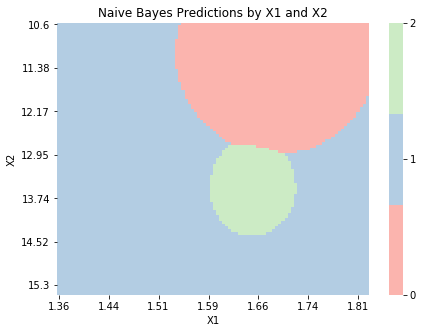

In [13]:
nb_2d = NaiveBayes()
nb_2d.fit(X_2d, y)
graph_boundaries(X_2d, nb_2d, 'Naive Bayes')